# CNN for rock-paper-scissors with Keras/TensorFlow

Date: January 4, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for CNN

In [27]:
DATA_FOLDER = '../thermography/data/'

FILES = 45
TRAINING_FILES = 30 
TEST_FILES = FILES - TRAINING_FILES

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp

In [29]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((pp.scale(data), class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((pp.scale(data), class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


array([[-0.70735509, -0.48652228,  0.25878845,  1.500973  ,  0.89368278,
        -0.56933459, -0.9281879 , -1.03860431],
       [-0.65214689, -0.70735509,  0.81087047,  1.500973  ,  1.55618121,
         0.45201716, -0.7625633 , -1.12141661],
       [-0.70735509, -0.21048127,  1.500973  ,  1.77701402,  1.63899351,
         1.4457648 , -0.43131408, -0.9281879 ],
       [-0.70735509,  0.17597615,  1.3629525 ,  1.63899351,  1.72180581,
         1.55618121,  0.94889098, -0.29329358],
       [-0.8453756 ,  0.67284997, -0.29329358,  1.16972379,  1.55618121,
         1.28014019,  0.06555974,  0.12076794],
       [-1.03860431, -0.7625633 , -0.9281879 ,  0.06555974,  1.08691148,
         0.39680895,  0.53482946, -0.70735509],
       [-1.31464532, -1.03860431, -1.03860431, -0.8453756 ,  0.53482946,
         0.45201716, -0.48652228, -0.70735509],
       [-1.25943712, -1.25943712, -1.25943712, -1.12141661, -0.9281879 ,
        -0.70735509, -0.8453756 , -1.03860431]])

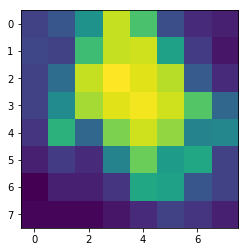

In [30]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data).reshape((TRAINING_FILES*len(class_labels), 8, 8, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data).reshape((TEST_FILES*len(class_labels), 8, 8, 1))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12,:,:,0])
train_data[12,:,:,0]

### CNN model

In [31]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(8, 8, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 8, 8, 16)          160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
__________

In [32]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

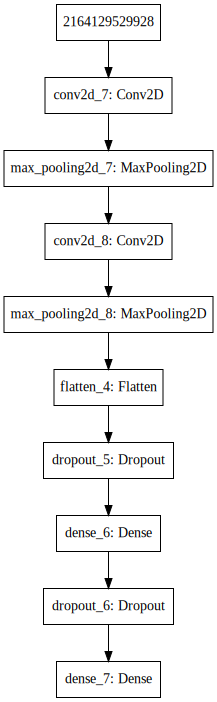

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [34]:
EPOCHS = 80
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 90 samples, validate on 45 samples
Epoch 1/80
90/90 [==============================] - 1s 8ms/step - loss: 1.1701 - acc: 0.3333 - val_loss: 1.0801 - val_acc: 0.4444
Epoch 2/80
90/90 [==============================] - 0s 261us/step - loss: 1.1078 - acc: 0.3778 - val_loss: 1.0517 - val_acc: 0.5111
Epoch 3/80
90/90 [==============================] - 0s 312us/step - loss: 1.0790 - acc: 0.4333 - val_loss: 1.0150 - val_acc: 0.5333
Epoch 4/80
90/90 [==============================] - 0s 292us/step - loss: 1.0647 - acc: 0.4444 - val_loss: 0.9869 - val_acc: 0.7778
Epoch 5/80
90/90 [==============================] - 0s 321us/step - loss: 1.0349 - acc: 0.4667 - val_loss: 0.9606 - val_acc: 0.8222
Epoch 6/80
90/90 [==============================] - 0s 333us/step - loss: 0.9976 - acc: 0.5333 - val_loss: 0.9252 - val_acc: 0.7556
Epoch 7/80
90/90 [==============================] - 0s 249us/step - loss: 0.9536 - acc: 0.5667 - val_loss: 0.8903 - val_acc: 0.8000
Epoch 8/80
90/90 [================

90/90 [==============================] - 0s 214us/step - loss: 0.0669 - acc: 0.9889 - val_loss: 0.1000 - val_acc: 0.9556
Epoch 63/80
90/90 [==============================] - 0s 266us/step - loss: 0.0828 - acc: 0.9778 - val_loss: 0.1312 - val_acc: 0.9556
Epoch 64/80
90/90 [==============================] - 0s 278us/step - loss: 0.0732 - acc: 0.9778 - val_loss: 0.1587 - val_acc: 0.9333
Epoch 65/80
90/90 [==============================] - 0s 308us/step - loss: 0.0614 - acc: 0.9778 - val_loss: 0.0599 - val_acc: 0.9556
Epoch 66/80
90/90 [==============================] - 0s 252us/step - loss: 0.0516 - acc: 0.9889 - val_loss: 0.1114 - val_acc: 0.9556
Epoch 67/80
90/90 [==============================] - 0s 308us/step - loss: 0.0381 - acc: 1.0000 - val_loss: 0.1059 - val_acc: 0.9556
Epoch 68/80
90/90 [==============================] - 0s 332us/step - loss: 0.0654 - acc: 0.9889 - val_loss: 0.1406 - val_acc: 0.9556
Epoch 69/80
90/90 [==============================] - 0s 251us/step - loss: 0.0250

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


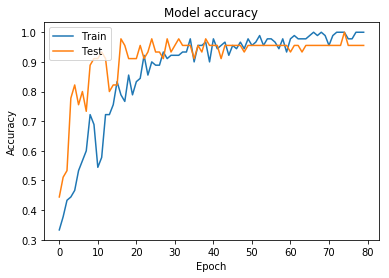

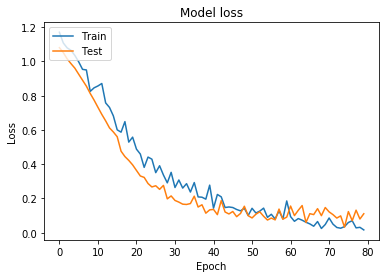

In [35]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [36]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_rock_paper_scissors{}.h5'.format(dt)
model.save(filename)

## Load the model

In [37]:
del model
model = models.load_model(filename)

## Confirmation

In [38]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(90, 8, 8, 1)

In [39]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [40]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [41]:
class_labels

['paper', 'rock', 'scissors']

In [42]:
(activations[-1][:10]*100).astype(int)

array([[ 0,  0, 99],
       [99,  0,  0],
       [95,  0,  3],
       [ 0, 99,  0],
       [ 0, 99,  0],
       [99,  0,  0],
       [85,  0, 14],
       [ 0,  0, 99],
       [ 0,  0, 99],
       [ 0, 99,  0]])

In [43]:
test_labels[:10].astype(int)

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]])

In [44]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(activations[layer][sample, :, :, i])
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'rock'

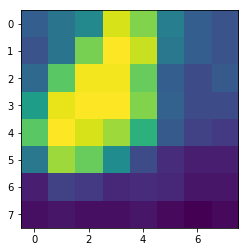

In [45]:
image_number = 10

plt.imshow(test_data[image_number,:,:,0])
class_labels[np.argmax(test_labels[image_number])]

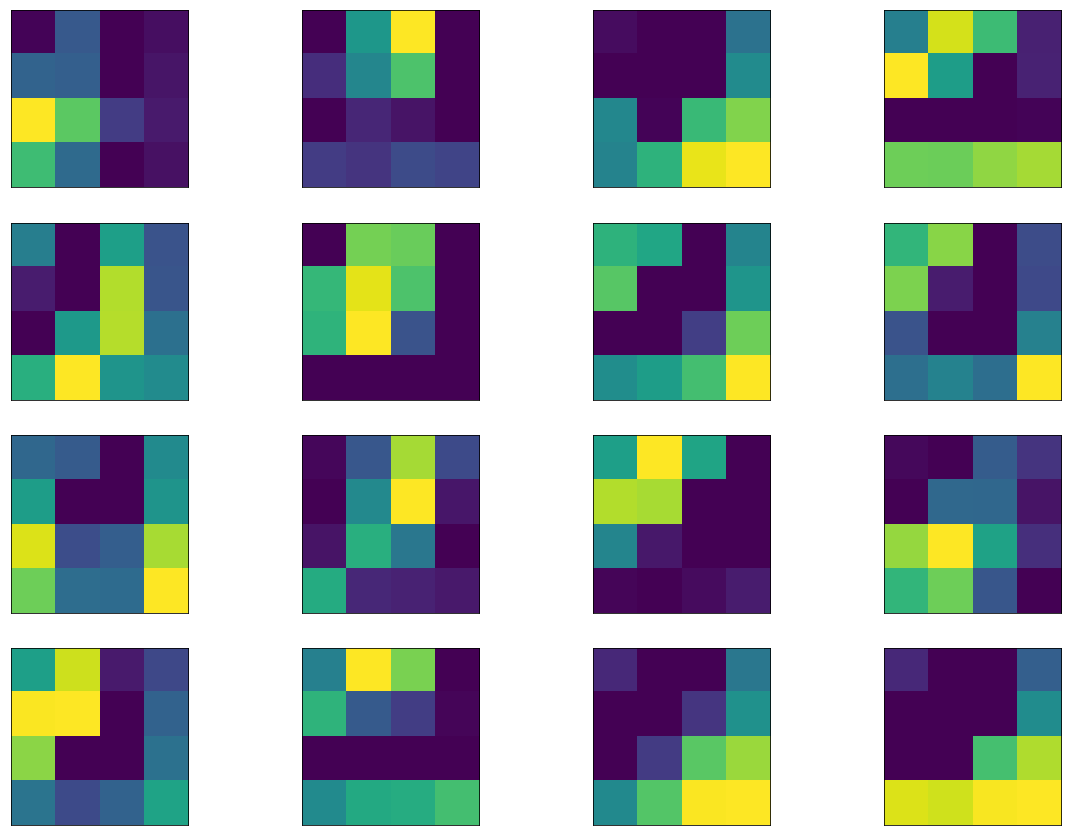

In [46]:
plot_layer(activations, image_number, 1)

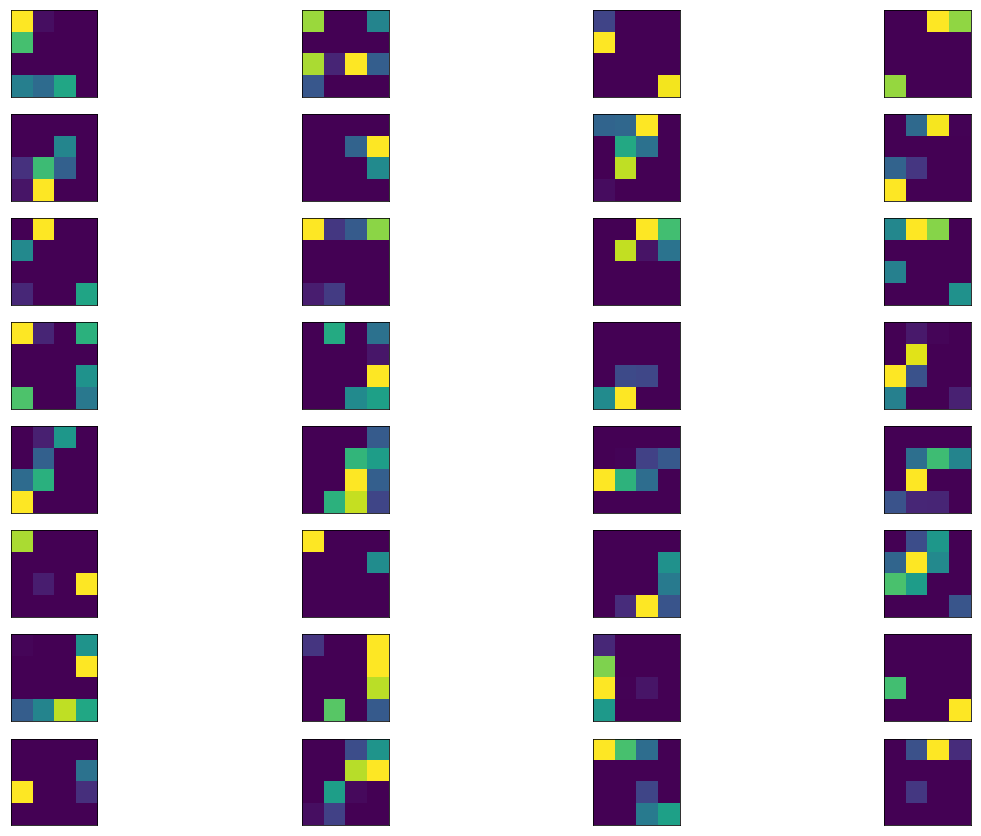

In [47]:
plot_layer(activations, image_number, 2)